In [1]:
import numpy as np
import matplotlib.pyplot as plt

from temporal_difference import TDAgent
from envs.gridworld import GridworldEnv
from utils.grid_visualization import visualize_value_function, visualize_policy

np.random.seed(0)

## `GridWorld` 초기화하기

가로로 `nx` 개, 세로로 `ny` 개의 칸을 가진 `GridworldEnv`를 만듭니다!

In [2]:
nx, ny = 4, 4
env = GridworldEnv([ny, nx])

## Temporal-difference '에이전트' 초기화하기

Temporal difference 에이전트를 초기화 해볼까요? TD 에이전트의 컨스트럭터는 다음과 같습니다.

```python
def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 epsilon: float,
                 lr: float,
                 n_step: int):
```

각각의 인자들의 의미부터 살펴볼까요?
1. `gamma` : 감가율
2. `num_states` : 상태공간의 크기 (서로 다른 상태의 갯수)
3. `num_actions` : 행동공간의 크기 (서로 다른 행동의 갯수)
4. `epsilon`: $\epsilon$-탐욕적 정책의 파라미터
5. `lr`: 학습률 $\alpha$
6. `n-step`: 리턴 추산에 사용할 스텝의 수

In [3]:
def run_episode(env, agent):
    env.reset()
    
    while True:
        state = env.observe()
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.sample_update(state=state, 
                            action=action, 
                            reward=reward,
                            next_state=next_state,
                            done=done)
        
        if done:
            break

## agent.sample_update() ?

TD 에이전트의 MC 장점 중 하나는 episode가 다 끝나지 않아도 업테이트를 수행할 수 있었다는 점이 있었죠? 그 특성을 활용해서 상태 및 행동 가치함수를 업데이트하는 코드를 살펴보죠.

```python
def sample_update(self, state, action, reward, next_state, done):
    # 1-step TD target
    td_target = reward + self.gamma * self.v[next_state] * (1 - done)
    self.v[state] += self.lr * (td_target - self.v[state])

```

In [4]:
total_eps = 10000
log_every = 1000

def run_episodes(env, agent, total_eps, log_every):
    values = []
    log_iters = []
    
    for i in range(total_eps+1):  
        run_episode(env, agent)

        if i % log_every == 0:
            values.append(agent.v.copy())
            log_iters.append(i)
    
    info = dict()
    info['values'] = values
    info['iters'] = log_iters
    return info

## 여러 스텝의 보상함수를 같이 활용하는 n-step TD

이번에는 n-step TD에 대해서 실습을 해보도록 할까요?

In [5]:
n_step_td_agent = TDAgent(gamma=1.0,
                          num_states=nx * ny,
                          num_actions=4,
                          epsilon=1.0,
                          lr=1e-2,
                          n_step=2)

In [6]:
def run_episode(env, agent):
    env.reset()
    states = []
    actions = []
    rewards = []
    
    while True:
        state = env.observe()
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
    
    episode = (states, actions, rewards)
    agent.update(episode)

In [7]:
n_step_td_agent.n_step

2

In [8]:
n_step_td_agent.reset_values()
info = run_episodes(env, n_step_td_agent, 10000, 1000)

In [9]:
log_iters = info['iters']
mc_values = info['values']

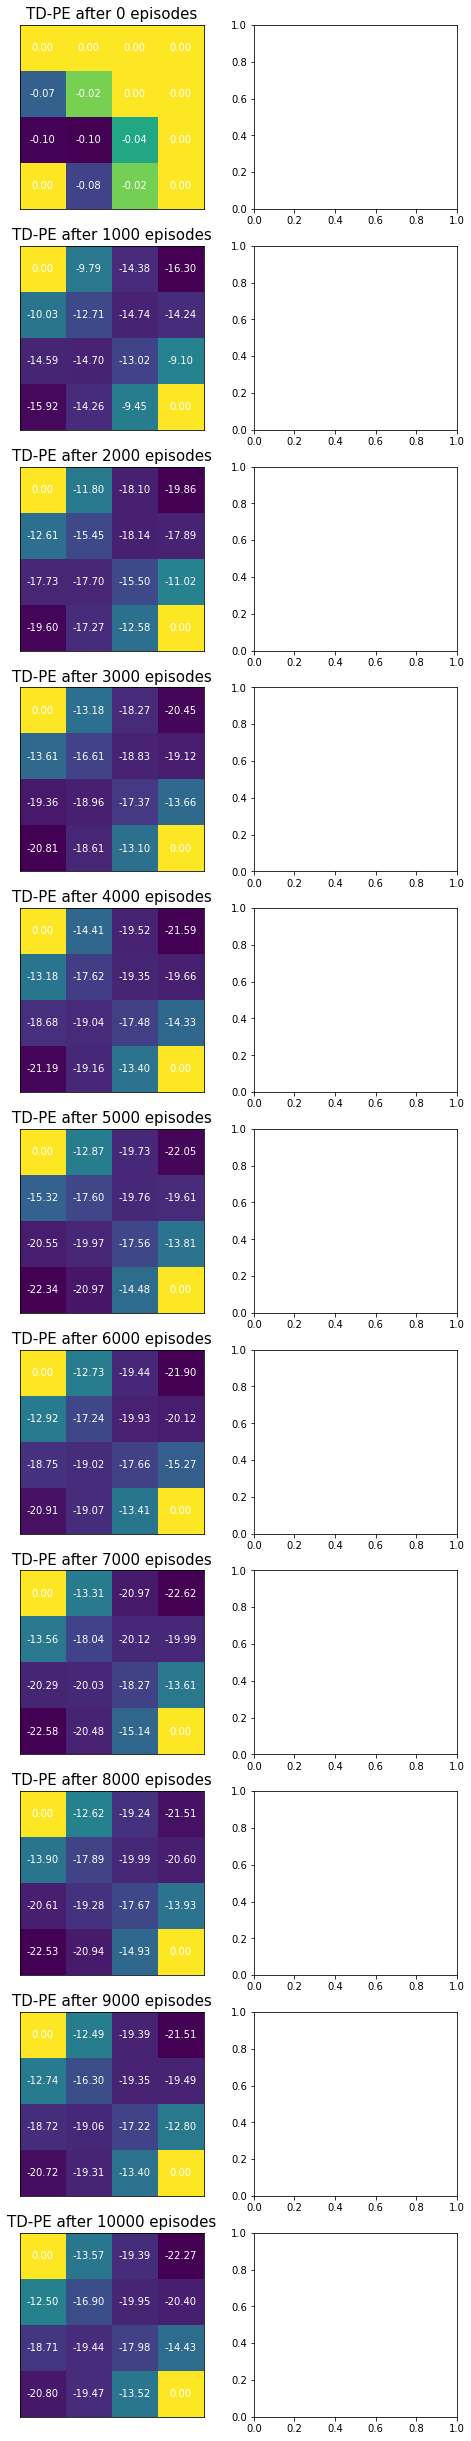

In [10]:
n_rows = len(log_iters)
figsize_multiplier = 4


fig, ax = plt.subplots(n_rows, 2, figsize=(2*figsize_multiplier, 
                                           n_rows*figsize_multiplier))

for viz_i, i in enumerate(log_iters):
    visualize_value_function(ax[viz_i, 0], mc_values[viz_i], nx, ny,
                            plot_cbar=False)
    _ = ax[viz_i, 0].set_title("TD-PE after {} episodes".format(i), size=15)

#     visualize_value_function(ax[viz_i, 1], v_pi, nx, ny,
#                              plot_cbar=False)
#     _ = ax[viz_i, 1].set_title("DP-PE", size=15)